In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

2024-03-12 17:32:02.575477: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 17:32:02.575585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 17:32:02.747979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = "/kaggle/input/eccv-brain-mri-augmentation-manual/original_dataset/"
num_classes = 4
accuracies = []

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.31,
  subset="training",
  seed=123,
  image_size=(224,224),
  batch_size=64)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.31,
  subset="validation",
  seed=123,
  image_size=(224,224),
  batch_size=64)

Found 3027 files belonging to 4 classes.
Using 2089 files for training.
Found 3027 files belonging to 4 classes.
Using 938 files for validation.


In [3]:
inc3 = InceptionV3(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)

87910968/87910968 [==============================] - 0s 0us/step


In [4]:
earlystopping = EarlyStopping(monitor="val_loss",
                                    mode="min", patience=5,
                                    restore_best_weights=True)

for layer in inc3.layers:
    layer.trainable = False

x = Flatten()(inc3.output)
prediction = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inc3.input, outputs=prediction)
model.summary()
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [5]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 30, callbacks=[earlystopping])

accuracy = history.history['val_accuracy'][-1]
accuracies.append(accuracy)
print(f"Overall accuracy: {accuracy}")

Epoch 1/30
 1/33 [..............................] - ETA: 6:13 - loss: 19.6875 - accuracy: 0.2500

I0000 00:00:1710264755.953043      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 [==============================] - 28s 501ms/step - loss: 91.8676 - accuracy: 0.4955 - val_loss: 32.8300 - val_accuracy: 0.5693
Epoch 2/30
33/33 [==============================] - 7s 192ms/step - loss: 14.4476 - accuracy: 0.7099 - val_loss: 13.6983 - val_accuracy: 0.6855
Epoch 3/30
33/33 [==============================] - 7s 191ms/step - loss: 8.7447 - accuracy: 0.7822 - val_loss: 13.4085 - val_accuracy: 0.7559
Epoch 4/30
33/33 [==============================] - 7s 197ms/step - loss: 4.5146 - accuracy: 0.8430 - val_loss: 11.3314 - val_accuracy: 0.7495
Epoch 5/30
33/33 [==============================] - 7s 192ms/step - loss: 5.0073 - accuracy: 0.8286 - val_loss: 11.2836 - val_accuracy: 0.7687
Epoch 6/30
33/33 [==============================] - 7s 198ms/step - loss: 3.1951 - accuracy: 0.8727 - val_loss: 10.6129 - val_accuracy: 0.7420
Epoch 7/30
33/33 [==============================] - 7s 198ms/step - loss: 1.3330 - accuracy: 0.9349 - val_loss: 8.6535 - val_accuracy: 0.8038
Epoch 8/

In [6]:
import tensorflow as tf

model.save('/kaggle/working/InceptionV3_original.h5')

# Save the history to a file
import pickle

with open('/kaggle/working/InceptionV3_original.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


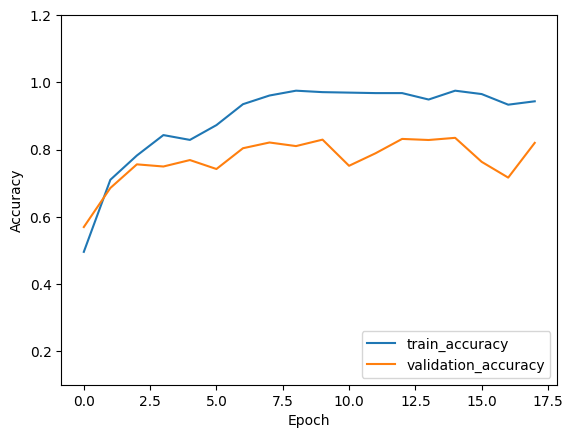

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1.2])
plt.legend(loc='lower right')

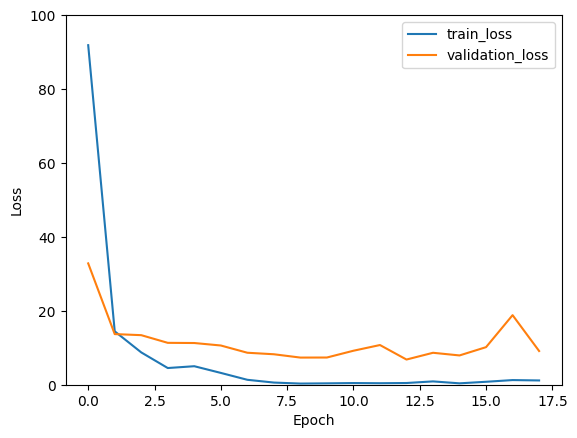

In [8]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 100])
plt.legend(loc='upper right')

2/2 [==============================] - 4s 2s/step


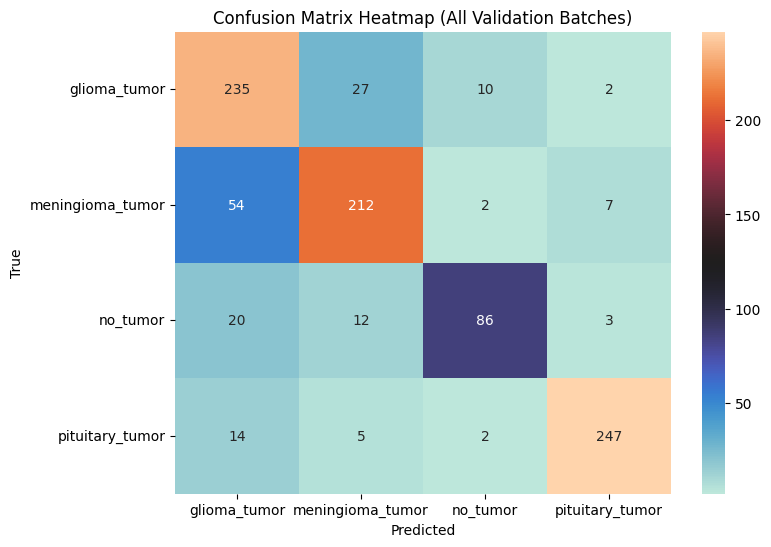

In [9]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_names = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

all_val_labels = []
all_val_predictions = []

# Evaluate the model on the validation dataset batch by batch
for batch in val_ds:
    val_images, val_labels_batch = batch
    val_predictions_batch = model.predict(val_images)

    val_labels_batch = np.array(val_labels_batch)
    val_predictions_batch = np.argmax(val_predictions_batch, axis=-1)

    all_val_labels.extend(val_labels_batch)
    all_val_predictions.extend(val_predictions_batch)

# Calculate the confusion matrix for all validation data
conf_matrix = confusion_matrix(all_val_labels, all_val_predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='icefire', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap (All Validation Batches)')
plt.show()

In [10]:
print(classification_report(all_val_labels, all_val_predictions, target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.73      0.86      0.79       274
meningioma_tumor       0.83      0.77      0.80       275
        no_tumor       0.86      0.71      0.78       121
 pituitary_tumor       0.95      0.92      0.94       268

        accuracy                           0.83       938
       macro avg       0.84      0.82      0.83       938
    weighted avg       0.84      0.83      0.83       938

